In [1]:
# ----------------------------
# Imports
# ----------------------------
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# ----------------------------
# 1. Dataset Class
# ----------------------------
class CXRDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Metadata features we keep
        self.meta_features = ['age', 'sex', 'RT_PCR_positive']

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")  # ensures 3 channels
        if self.transform:
            image = self.transform(image)

        # Map sex to numeric
        sex_map = {"M": 0, "F": 1}
        sex_value = sex_map.get(row["sex"], 0)  # default 0 if missing

        # Age: replace NaN with mean or 0
        age_value = row["age"] if pd.notna(row["age"]) else 0.0

        # RT-PCR: assume column is 1 = positive, 0 = negative
        rtpcr_value = row["RT_PCR_positive"] if pd.notna(row["RT_PCR_positive"]) else 0.0

        # Now include all 3 features
        metadata = torch.tensor([age_value, sex_value, rtpcr_value], dtype=torch.float32)

        label = torch.tensor(row["label"], dtype=torch.long)

        return image, metadata, label



# ----------------------------
# 2. Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # standard ImageNet normalization
        std=[0.229, 0.224, 0.225]
    )
])


# ----------------------------
# 3. Dataset + DataLoader
# ----------------------------
csv_file = "../data/metadata_sample.csv"  # path to your simplified CSV
img_dir = "../data/images_sample"                 # path to your real chest X-ray images

dataset = CXRDataset(csv_file, img_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# ----------------------------
# 4. Test a batch
# ----------------------------
images, metadata, labels = next(iter(dataloader))
print("Images shape:", images.shape)        # [B, 3, 224, 224]
print("Metadata shape:", metadata.shape)    # [B, 3]
print("Labels shape:", labels.shape)        # [B]




Images shape: torch.Size([4, 3, 224, 224])
Metadata shape: torch.Size([4, 3])
Labels shape: torch.Size([4])


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Example disease labels (change to match your dataset!)
CLASS_NAMES = ["Healthy", "Pneumonia", "Tuberculosis", "Other"]

# Image Encoder
class ImageEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super(ImageEncoder, self).__init__()
        backbone = models.resnet18(pretrained=True)
        in_features = backbone.fc.in_features
        backbone.fc = nn.Identity()  # remove classifier
        self.backbone = backbone
        self.fc = nn.Linear(in_features, output_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        return x

# Metadata Encoder
class MetaEncoder(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



# Fusion Model
class FusionModel(nn.Module):
    def __init__(self, img_dim=128, meta_dim=128, hidden_dim=64, num_classes=2):
        super(FusionModel, self).__init__()
        self.img_encoder = ImageEncoder(output_dim=img_dim)

        # FIXED: use MetaEncoder with input_dim=3
        self.meta_encoder = MetaEncoder(input_dim=3, hidden_dim=64, output_dim=meta_dim)


        self.classifier = nn.Sequential(
            nn.Linear(img_dim + meta_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, images, metadata):
        img_features = self.img_encoder(images)          # [B, img_dim]
        meta_features = self.meta_encoder(metadata)      # [B, meta_dim]
        fused = torch.cat([img_features, meta_features], dim=1)
        logits = self.classifier(fused)                  # raw scores

        if logits.shape[1] == 1:  # binary classification
            probs = torch.sigmoid(logits)
        else:  # multi-class
            probs = torch.softmax(logits, dim=1)

        return probs
    
# Instantiate model
model = FusionModel()

# Run one forward pass using a batch from your dataloader
out = model(images, metadata)

# Print results
print("Classifier output shape:", out.shape)   # Expect [B, 2]
print("Classifier output (probabilities):")
print(out)
print("Row sums (should be ~1.0 for softmax):", out.sum(dim=1))

    


d:\Anaconda\envs\cxr-multimodal\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\cxr-multimodal\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Classifier output shape: torch.Size([4, 2])
Classifier output (probabilities):
tensor([[0.4477, 0.5523],
        [0.4521, 0.5479],
        [0.3716, 0.6284],
        [0.4869, 0.5131]], grad_fn=<SoftmaxBackward0>)
Row sums (should be ~1.0 for softmax): tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


: 

In [3]:
# ----------------------------
# 6. Training Setup (Prototype Friendly)
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionModel(num_classes=2).to(device)

# Freeze ResNet backbone to avoid overfitting on tiny dataset
for param in model.img_encoder.backbone.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train/Val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# ----------------------------
# 7. Training Loop (Prototype)
# ----------------------------
num_epochs = 10
best_val_loss = float('inf')
best_model_wts = model.state_dict()
patience = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, metadata, labels in train_loader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, metadata, labels in val_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Load best model weights
model.load_state_dict(best_model_wts)


Epoch [1/10] Train Loss: 0.3263 Train Acc: 1.0000 | Val Loss: 0.4139 Val Acc: 0.9000
Epoch [2/10] Train Loss: 0.3137 Train Acc: 1.0000 | Val Loss: 0.4136 Val Acc: 0.9000
Epoch [2/10] Train Loss: 0.3137 Train Acc: 1.0000 | Val Loss: 0.4136 Val Acc: 0.9000
Epoch [3/10] Train Loss: 0.3135 Train Acc: 1.0000 | Val Loss: 0.4135 Val Acc: 0.9000
Epoch [3/10] Train Loss: 0.3135 Train Acc: 1.0000 | Val Loss: 0.4135 Val Acc: 0.9000
Epoch [4/10] Train Loss: 0.3135 Train Acc: 1.0000 | Val Loss: 0.4135 Val Acc: 0.9000
Epoch [4/10] Train Loss: 0.3135 Train Acc: 1.0000 | Val Loss: 0.4135 Val Acc: 0.9000
Epoch [5/10] Train Loss: 0.3134 Train Acc: 1.0000 | Val Loss: 0.4134 Val Acc: 0.9000
Epoch [5/10] Train Loss: 0.3134 Train Acc: 1.0000 | Val Loss: 0.4134 Val Acc: 0.9000
Epoch [6/10] Train Loss: 0.3134 Train Acc: 1.0000 | Val Loss: 0.4134 Val Acc: 0.9000
Epoch [6/10] Train Loss: 0.3134 Train Acc: 1.0000 | Val Loss: 0.4134 Val Acc: 0.9000
Epoch [7/10] Train Loss: 0.3134 Train Acc: 1.0000 | Val Loss: 0.4

<All keys matched successfully>

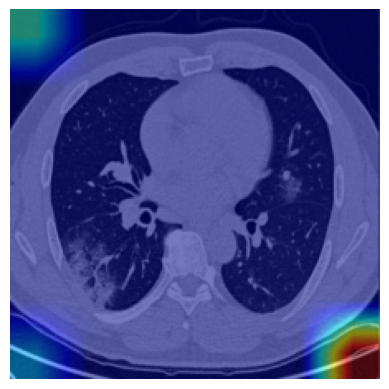

In [10]:
# ----------------------------
# Grad-CAM for Image Encoder (FusionModel)
# ----------------------------
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np

# Use the image encoder part of FusionModel
img_model = model.img_encoder
img_model.eval()

# Pick target layer (last conv layer of ResNet18 backbone)
target_layer = img_model.backbone.layer4[-1]

# Take first image from dataloader
images, metadata, labels = next(iter(dataloader))
images = images.to(device)
labels = labels.to(device)
images.requires_grad = True  # Grad-CAM requires this

# Initialize Grad-CAM
cam = GradCAM(model=img_model, target_layers=[target_layer])

# Compute Grad-CAM for the first image and its target class
grayscale_cam = cam(input_tensor=images[:1], 
                    targets=[ClassifierOutputTarget(labels[0].item())])[0, :]

# Convert to RGB for visualization
rgb_img = images[0].detach().cpu().permute(1,2,0).numpy()  # detach() added
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display
plt.imshow(cam_image)
plt.axis('off')
plt.show()



Metadata shape: (4, 3)
SHAP values shape: (3, 2)
SHAP values have fewer columns (2), padding to 3.
Final Metadata shape: (3, 3)
Final SHAP values shape: (3, 3)


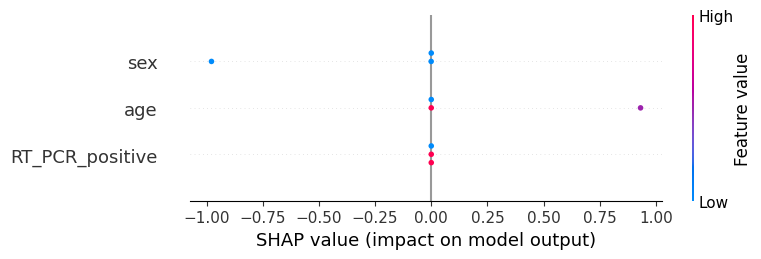

In [11]:
# ----------------------------
# Robust SHAP for metadata only (always 3 features)
# ----------------------------
import shap

# Use wrapper as before
class MetaWrapper(nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, x):
        x = self.encoder(x)
        # Dummy image features = zeros, same batch size
        dummy_img = torch.zeros(x.size(0), model.img_encoder.fc.out_features)
        x = torch.cat([dummy_img, x], dim=1)
        out = self.classifier(x)
        return out

wrapper = MetaWrapper(model.meta_encoder, model.classifier)
wrapper.eval()

# Use CPU
background = metadata[:5].to('cpu')  # background
sample = metadata[:10].to('cpu')     # samples to explain

# SHAP DeepExplainer
explainer = shap.DeepExplainer(wrapper, background)

# Compute SHAP values
shap_values_all = explainer.shap_values(sample)  # list: one per class

# Pick class 1 (positive)
shap_class1 = shap_values_all[1]

# Ensure sample matches SHAP rows
sample_np = sample.numpy()

print("Metadata shape:", sample_np.shape)        # should be [num_samples, 3]
print("SHAP values shape:", shap_class1.shape)   # can be [num_samples, N]

# --- Fix: Always 3 columns for SHAP and sample_np ---
num_samples = min(shap_class1.shape[0], sample_np.shape[0])
shap_class1 = shap_class1[:num_samples]
sample_np = sample_np[:num_samples]

# 1. If shap_class1 has extra columns, drop them
if shap_class1.shape[1] > 3:
    print(f"SHAP values have extra columns ({shap_class1.shape[1]}), dropping to 3.")
    shap_class1 = shap_class1[:, :3]
# 2. If shap_class1 has fewer columns, pad with zeros
elif shap_class1.shape[1] < 3:
    print(f"SHAP values have fewer columns ({shap_class1.shape[1]}), padding to 3.")
    pad_width = 3 - shap_class1.shape[1]
    shap_class1 = np.pad(shap_class1, ((0,0),(0,pad_width)), mode='constant')

# 3. Ensure sample_np has exactly 3 columns
if sample_np.shape[1] > 3:
    sample_np = sample_np[:, :3]
elif sample_np.shape[1] < 3:
    pad_width = 3 - sample_np.shape[1]
    sample_np = np.pad(sample_np, ((0,0),(0,pad_width)), mode='constant')

feature_names = ['age', 'sex', 'RT_PCR_positive']

print("Final Metadata shape:", sample_np.shape)
print("Final SHAP values shape:", shap_class1.shape)

# Plot
shap.summary_plot(
    shap_class1,
    features=sample_np,
    feature_names=feature_names
)


Confusion Matrix:
 [[ 0  2]
 [ 0 18]]
Classification Report:
               precision    recall  f1-score   support

  No Disease       0.00      0.00      0.00         2
     Disease       0.90      1.00      0.95        18

    accuracy                           0.90        20
   macro avg       0.45      0.50      0.47        20
weighted avg       0.81      0.90      0.85        20

ROC-AUC Score: 0.6666666666666667


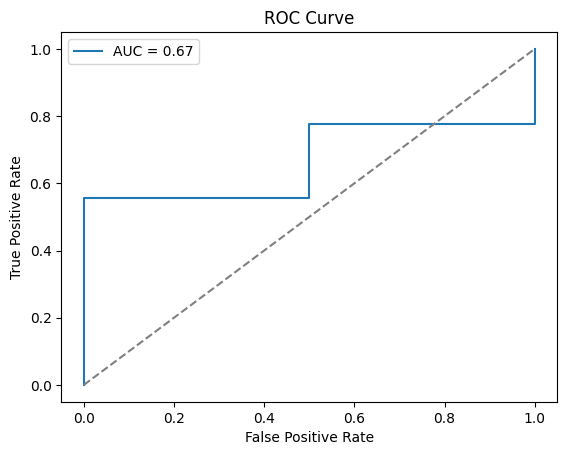

In [12]:
# ----------------------------
# Evaluation Metrics
# ----------------------------
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, metadata, labels in val_loader:   # loop over validation/test set
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

        probs = model(images, metadata)           # forward pass -> probabilities
        preds = torch.argmax(probs, dim=1)        # predicted class indices

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 0].cpu().numpy())  # probs for "disease" class

# Convert to numpy
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

# Classification Report
from sklearn.metrics import classification_report

# Explicitly define labels = [0,1] so both classes are included
report = classification_report(
    all_labels, 
    all_preds, 
    labels=[0,1], 
    target_names=["No Disease", "Disease"],
    zero_division=0  # avoids crash if a metric is undefined
)
print("Classification Report:\n", report)


# ROC & AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)
print("ROC-AUC Score:", auc_score)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [83]:
import os
import shutil
import pandas as pd

# Paths
csv_file = "../data/metadata_sample.csv"   # your sample CSV
all_images_dir = "../data/covid-chestxray-dataset/images"   # root folder where you downloaded full COVIDx dataset
sample_images_dir = "../data/images_sample"
os.makedirs(sample_images_dir, exist_ok=True)

# Load metadata
df = pd.read_csv(csv_file)

valid_rows = []
not_found = []

# For each filename, check if it exists
for _, row in df.iterrows():
    fname = row['filename']
    found = False
    for root, _, files in os.walk(all_images_dir):
        if fname in files:
            src = os.path.join(root, fname)
            dst = os.path.join(sample_images_dir, fname)
            shutil.copy(src, dst)
            valid_rows.append(row)  # keep row if file exists
            found = True
            break
    if not found:
        not_found.append(fname)

# Create a new DataFrame with only valid rows
df_valid = pd.DataFrame(valid_rows)

# Overwrite the original metadata file (or save as new file)
df_valid.to_csv("../data/metadata_sample_cleaned.csv", index=False)

print("✅ Finished copying & cleaning metadata!")
if not_found:
    print("⚠️ Removed rows for missing files:", not_found)


✅ Finished copying & cleaning metadata!
